# CS 4820
# Assignment 11: Time Series and Recurrent Neural Networks (RNN)

In Tutorail 11, you successfully predicted the electric load of the next hour and now we would like to push it further. Let's see if your model (with the following changes) can predict the load __in 36 hours__ instead of the next hour.

- The entire section 1 "Time series forecasting" should stay the same between Tutorial 11 and this assignment.
- In section 2 "LSTM model" below, set the following before using the helper `function create_lagged_Xy_win` to generate new X and y pairs 
    - `start_lag=36`
    - `window_len=72`
- Still in section 2 "LSTM model" below, build an LSTM model of three layers
    - One LSTM layer of 12 LSTM units. Set `kernel_initializer='normal'`. Also, set `return_sequences=True` since there is another LSTM layer following this one.
    - Another LSTM layer of 6 LSTM units. Set `kernel_initializer='normal'`. No need to set `return_sequences=True` since this is the last LSTM layer.
    - One last layer of `Dense(1)`.
- Train, test, and evaluate your model like what you did in Tutorial 11.


### 1. Time series forecasting

Load and pre-process the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#reading the data from the file provided
fname = './data/ZonalDemands_2003-2016.csv.bz2'
df = pd.read_csv(fname, compression='bz2',
                 engine='python')

#defining and using the function to combine the 
#date and time of each record together
def combine_date_hour(row):
    date = pd.to_datetime(row['Date'])
    hour = pd.Timedelta("%d hours" % row['Hour'])
    return date + hour

idx = df.apply(combine_date_hour, axis=1)
df = df.set_index(idx)

#defining a location from which to split the data
#into a training set and testing set
split_date = pd.Timestamp('01-01-2014')
train = df.loc[:split_date, ['Total Ontario']].copy()
test = df.loc[split_date:, ['Total Ontario']].copy()


#scaling the data to be more resonable, then into
#the train/test X and y
offset = 10000
scale = 5000

train_sc = (train - offset) / scale
test_sc = (test - offset) / scale

X_train = train_sc[:-1].values
y_train = train_sc[1:].values

X_test = test_sc[:-1].values
y_test = test_sc[1:].values

### 2. Long Short Term Memory (LSTM) Neural Networks Model

#### 2.1 Rolling windows

In [28]:
win_len = 72
start_lag = 36

In [29]:
def create_lagged_Xy_win(data, start_lag=1,
                         window_len=1):
    X = data.shift(start_lag + window_len - 1).copy()
    X.columns = ['T_{}'.format(start_lag + window_len - 1)]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            col_ = 'T_{}'.format(start_lag + s - 1)
            X[col_] = data.shift(start_lag + s - 1)

    X = X.dropna()
    idx = X.index
    y = data.loc[idx]
    return X, y

In [32]:
X_train, y_train = create_lagged_Xy_win(train_sc, start_lag, win_len)
X_test, y_test = create_lagged_Xy_win(test_sc, start_lag, win_len)


X_train_t = X_train.values.reshape(-1, win_len, 1)
X_test_t = X_test.values.reshape(-1, win_len, 1)

y_train_t = y_train.values
y_test_t = y_test.values

#### 2.2 Model construction

In [33]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense

K.clear_session()

In [35]:
model = Sequential()
model.add(LSTM(12, input_shape=(win_len, 1),
               kernel_initializer='normal',
               return_sequences=True))
model.add(LSTM(6, kernel_initializer='normal'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0005) )

In [36]:
model.fit(X_train_t, y_train_t,
          epochs=10,
          batch_size=256,
          verbose=1)

Epoch 1/10
93445/93445 [==============================] - 26s 281us/sample - loss: 0.4015 - l
Epoch 2/10
93445/93445 [==============================] - 24s 258us/sample - loss: 0.1667
Epoch 3/10
93445/93445 [==============================] - 25s 268us/sample - loss: 0.1093
Epoch 4/10
93445/93445 [==============================] - 24s 253us/sample - loss: 0.1077
Epoch 5/10
93445/93445 [==============================] - 23s 246us/sample - loss: 0.1056 
Epoch 6/10
93445/93445 [==============================] - 23s 244us/sample - loss: 0.1044
Epoch 7/10
93445/93445 [==============================] - 23s 248us/sample - loss: 0.1029
Epoch 8/10
93445/93445 [==============================] - 23s 248us/sample - loss: 0.1017
Epoch 9/10
93445/93445 [==============================] - 23s 249us/sample - loss: 0.1005
Epoch 10/10
93445/93445 [==============================] - 23s 248us/sample - loss: 0.0984


#### 2.3 Model evaluation

For your reference, the following is a small part of my predictive model to compare train and test.

![LSTM 36 hours](./assets/LSTM_36_hours.png)

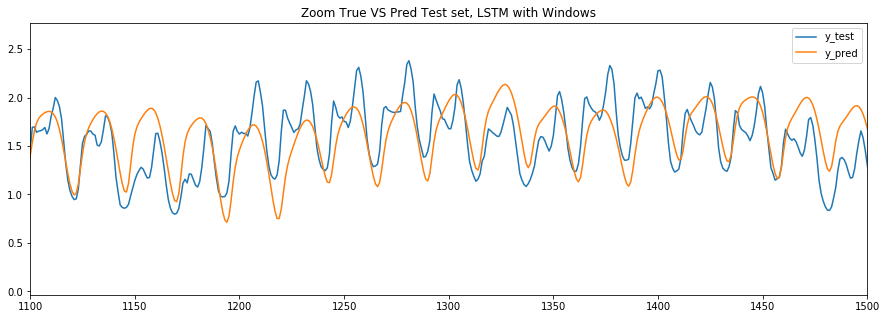

In [38]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1100,1500)
plt.title("Zoom True VS Pred Test set, LSTM with Windows");

In [39]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.35
Shift: -4, Corr: 0.49
Shift: -3, Corr: 0.62
Shift: -2, Corr: 0.72
Shift: -1, Corr: 0.78
Shift:  0, Corr: 0.79
Shift:  1, Corr: 0.75
Shift:  2, Corr: 0.68
Shift:  3, Corr: 0.57
Shift:  4, Corr: 0.45
